# Stacked Auto Encoder

# Question. What are autoencoders good for?

- Today two interesting practical applications of autoencoders are data denoising, and dimensionality reduction for data visualization.
- With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

## Keras Functional API

- At this time, I should introduce Keras Functional API.

- The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

- Check this gentle introduction to Keras Functional API

  - https://machinelearningmastery.com/keras-functional-api-deep-learning/


## A Simple Autoencoder based on a Fully-Connected Layer

- A Simple Autoencoder based on a Fully-Connected Layer

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg">

  - "Autoencoding" is a data compression algorithm
  - To build an autoencoder, you need three things: 
    - encoding function
    - decoding function
    - distance function: distance between the compressed representation and the decompressed representation

  - https://blog.keras.io/building-autoencoders-in-keras.html

### Model Define

In [0]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Data Import

In [0]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Train

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1476 - val_loss: 0.1446
Epoch 2/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1445 - val_loss: 0.1417
Epoch 3/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1417 - val_loss: 0.1390
Epoch 4/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1391 - val_loss: 0.1363
Epoch 5/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1366 - val_loss: 0.1340
Epoch 6/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1342 - val_loss: 0.1316
Epoch 7/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1320 - val_loss: 0.1294
Epoch 8/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1298 - val_loss: 0.1272
Epoch 9/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1278 - val_loss: 0.1252
Epoch

### Prediction

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

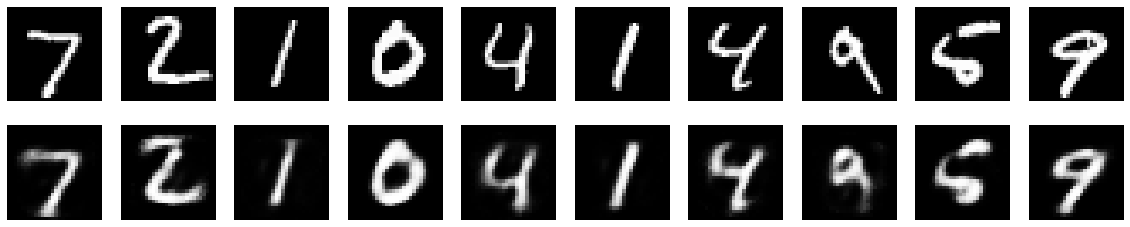

In [13]:
%matplotlib inline
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding a sparsity constraint on the encoded representations


- In the previous example, the representations were only constrained by the size of the hidden layer (32). 
- In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). 
- But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. 
- In Keras, this can be done by adding an activity_regularizer to our Dense layer:
  - Note. A tutorial code from the Keras document is somehow odds. Their regularization is so strong. I never reach such a reconstruction performance with 10e-5. I reduce this to 10e-8

### Model Define

In [0]:
import tensorflow.keras.backend as K
K.clear_session()

In [0]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-8))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

### Train

In [10]:
# Let's train this model for 100 epochs 
# (with the added regularization the model is less likely 
# to overfit and can be trained longer).

# Previously (without regularizers) we only use 20 epoch

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.3756 - val_loss: 0.2738
Epoch 2/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.2672 - val_loss: 0.2572
Epoch 3/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.2477 - val_loss: 0.2363
Epoch 4/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.2295 - val_loss: 0.2205
Epoch 5/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.2156 - val_loss: 0.2077
Epoch 6/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.2039 - val_loss: 0.1972
Epoch 7/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.1944 - val_loss: 0.1887
Epoch 8/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.1867 - val_loss: 0.1819
Epoch 9/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.1807 - val_loss: 0.1

### Prediction

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

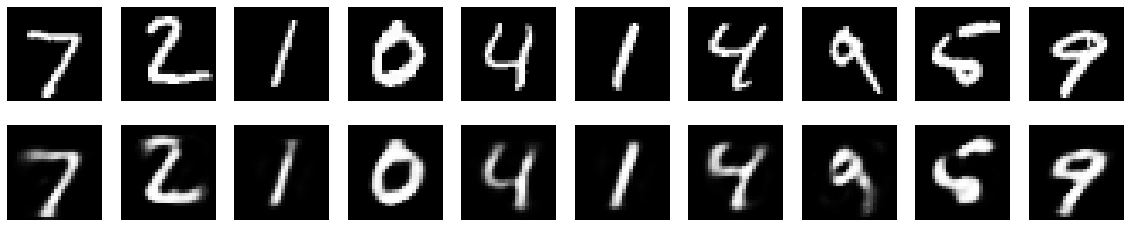

In [12]:
%matplotlib inline
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()